In [1]:
import torch
import time
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device
from snn_delays.utils.test_behavior import tb_save_max_last_refact

device = get_device()

# for reproducibility
torch.manual_seed(10)

'''
Remarks:
- experimenting with crop_to: this add different time-axis compression, should help with the generalization problem
'''

dataset = 'shd'
total_time = 50
batch_size = 1024

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  crop_to=1e6)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()

Running on: cuda:0
[CropTime(min=0, max=1000000.0), ToFrame(sensor_size=(700, 1, 1), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]


Delta t: 20.0 ms
SNN(
  (layers): ModuleList(
    (0): FlattenSNNLayer()
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=700, out_features=64, bias=False)
      (tdbn): TDBatchNorm1d(
        (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=2560, out_features=64, bias=False)
      (tdbn): TDBatchNorm1d(
        (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=20, bias=False)
    )
  )
  (criterion): MSELoss()
)
Epoch [1/30], learning_rates 0.001000, 0.100000
Step [2/7], Loss: 0.05932
Step [4/7], Loss: 0.04796
Step [6/7], Loss: 0.04539
Step [8/7], Loss: 0.04511
Time elasped: 2.4596023559570312
2264
Test Loss: 0.05116681878765424
Avg spk_count per neuron for all 50 time-steps 3011.660188457008
Test Accuracy of the model on the

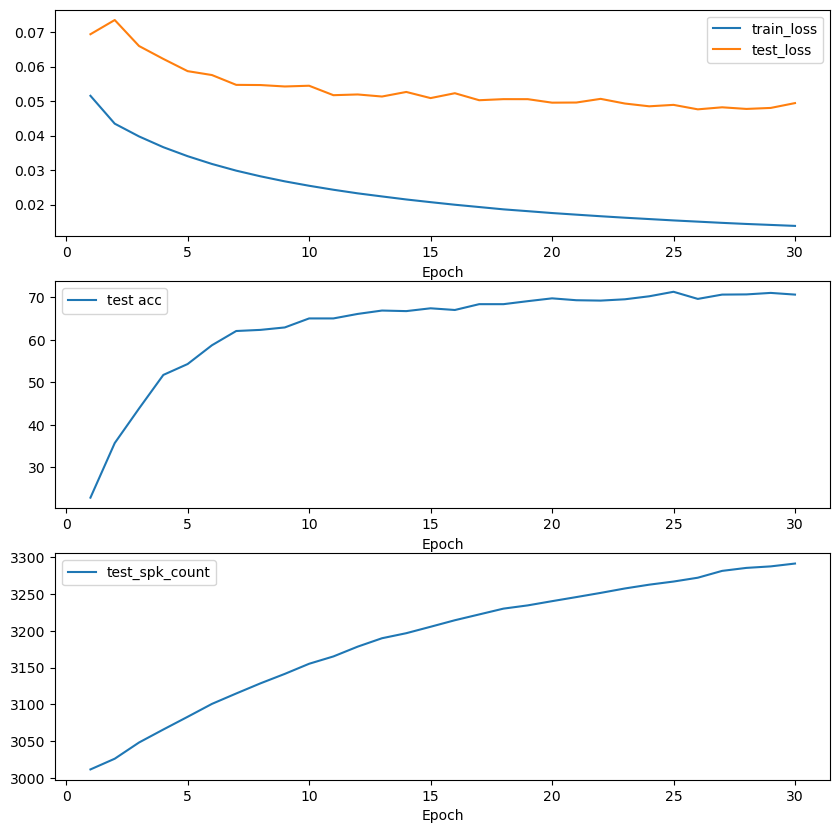

In [ ]:
tau_m = 20.0

model_config = [
    {'type': 'Flatten'},
    {
        'type': 'Feedforward', 
        'num_out': 64, # Number of neurons in this dense layer
    },
    {
        'type': 'Feedforward', 
        'num_out': 64, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 40, 'stride': 1, 'pruned_delays':3}
    }    
]

snn = SNN(dataset_dict=dataset_dict, model_config=model_config,
    tau_m = tau_m, win=total_time, loss_fn='spk_count', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

num_epochs = 30
lr = 1e-3
ckpt_dir = 'tests'

train(snn, train_loader, test_loader, lr, num_epochs, lr_tau=1e-1, test_behavior=tb_save_max_last_refact, ckpt_dir=ckpt_dir, scheduler=(100, 0.95), test_every=1)

In [6]:
[param for name, param in snn.named_parameters() if 'tdbn' in name]

[Parameter containing:
 tensor([1.2320, 1.5212, 1.0293, 1.0373, 0.9741, 1.2097, 1.1705, 0.8025, 0.9582,
         1.2804, 1.2157, 1.0373, 1.2127, 0.8893, 1.1252, 1.1888, 1.1996, 1.2712,
         1.1266, 1.1182, 0.9699, 0.9481, 1.1550, 1.0214, 0.9165, 0.9454, 1.3620,
         1.2309, 1.4753, 1.3733, 0.7186, 1.4811, 1.0602, 1.0408, 0.9109, 1.2183,
         1.0411, 1.0947, 1.0004, 1.0908, 0.9174, 1.1981, 0.9730, 1.3063, 0.8612,
         1.2771, 1.0657, 0.8392, 1.0476, 1.1124, 0.9283, 1.0148, 1.0260, 0.9493,
         0.9073, 1.2198, 1.2488, 1.1034, 0.9426, 0.9623, 1.1955, 1.0671, 1.2590,
         1.0549], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([1.8347, 1.4090, 1.9848, 2.3473, 2.6520, 1.9446, 2.0426, 0.6710, 1.9422,
         1.7250, 2.4688, 1.4088, 0.7549, 2.5058, 2.1662, 2.0707, 1.6040, 2.6073,
         1.8497, 1.2226, 2.3043, 2.3335, 1.0150, 1.3318, 2.1011, 2.0581, 2.5176,
         1.6156, 1.5900, 2.9008, 1.7919, 1.0321, 1.4126, 2.6901, 2.7108, 3.0325,
       

Delta t: 20.0 ms
SNN(
  (layers): ModuleList(
    (0): FlattenSNNLayer()
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=700, out_features=64, bias=False)
      (tdbn): TDBatchNorm1d(
        (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2-5): 4 x FeedforwardSNNLayer(
      (linear): Linear(in_features=320, out_features=64, bias=False)
      (tdbn): TDBatchNorm1d(
        (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (6): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=20, bias=False)
    )
  )
  (criterion): MSELoss()
)
Epoch [1/30], learning_rates 0.001000, 0.100000


Step [2/7], Loss: 0.05074
Step [4/7], Loss: 0.04865
Step [6/7], Loss: 0.04838
Step [8/7], Loss: 0.04816
Time elasped: 6.566421270370483
2264
Test Loss: 0.052923496812582016
Avg spk_count per neuron for all 50 time-steps 1768.8987779740871
Test Accuracy of the model on the test samples: 6.537

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\tests
saving max acc: 6.5371024734982335
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\tests
Epoch [2/30], learning_rates 0.001000, 0.100000
Step [2/7], Loss: 0.04830
Step [4/7], Loss: 0.04824
Step [6/7], Loss: 0.04830
Step [8/7], Loss: 0.04789
Time elasped: 6.490432500839233
2264
Test Loss: 0.05461159348487854
Avg spk_count per neuron for all 50 time-steps 1768.1945671378091
Test Accuracy of the model on the test samples: 8.260

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\tests
saving max acc: 8.259717314487633
Model sa

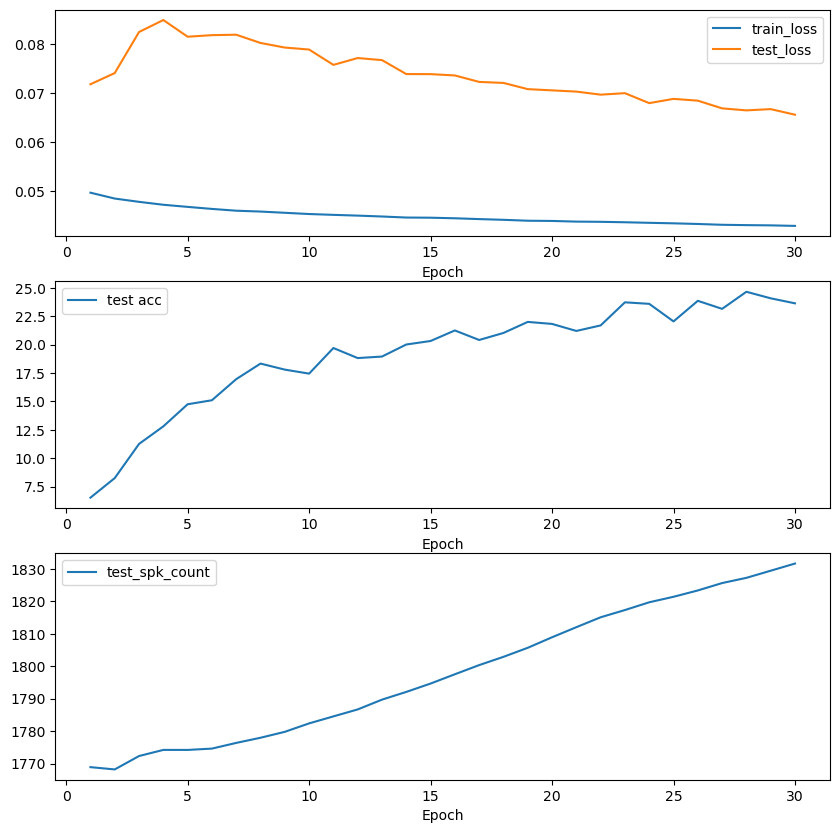

In [8]:
tau_m = 20.0

model_config = [
    {'type': 'Flatten'},
    {
        'type': 'Feedforward', 
        'num_out': 64, # Number of neurons in this dense layer
    },
    {
        'type': 'Feedforward', 
        'num_out': 64, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 5, 'stride': 1, 'pruned_delays':3}
    },    
    {
        'type': 'Feedforward', 
        'num_out': 64, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 5, 'stride': 1, 'pruned_delays':3}
    },    
    {
        'type': 'Feedforward', 
        'num_out': 64, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 5, 'stride': 1, 'pruned_delays':3}
    },    
    {
        'type': 'Feedforward', 
        'num_out': 64, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 5, 'stride': 1, 'pruned_delays':3}
    }        
]

snn = SNN(dataset_dict=dataset_dict, model_config=model_config,
    tau_m = tau_m, win=total_time, loss_fn='spk_count', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

num_epochs = 30
lr = 1e-3
ckpt_dir = 'tests'

train(snn, train_loader, test_loader, lr, num_epochs, lr_tau=1e-1, test_behavior=tb_save_max_last_refact, ckpt_dir=ckpt_dir, scheduler=(100, 0.95), test_every=1)